
References: 
1. http://ipywidgets.readthedocs.io/en/latest/examples/Lorenz%20Differential%20Equations.html
2. https://github.com/mspieg/dynamical-systems/blob/master/LorenzEquations.ipynb
3. https://en.wikipedia.org/wiki/List_of_dynamical_systems_and_differential_equations_topics
4. http://ipython-books.github.io/chapter-12-deterministic-dynamical-systems/
http://ipython-books.github.io/
5. http://adventuresinmachinelearning.com/recurrent-neural-networks-lstm-tutorial-tensorflow/
6. http://iamtrask.github.io/2015/11/15/anyone-can-code-lstm/
7. http://colah.github.io/posts/2015-08-Understanding-LSTMs/
8. http://www.iro.umontreal.ca/~lisa/pointeurs/RazvanPascanuThesis.pdf (also in downloads)
9. https://www.gribblelab.org/compneuro/2_Modelling_Dynamical_Systems.html#orgheadline5 
10. https://blog.statsbot.co/time-series-prediction-using-recurrent-neural-networks-lstms-807fa6ca7f
11. https://github.com/yuqirose/trnn poster - http://roseyu.com/Materials/nips17-tsw-poster.pdf
12. https://machinelearningmastery.com/prepare-univariate-time-series-data-long-short-term-memory-networks/

In [1]:
from ipywidgets import interact, interactive
from IPython.display import clear_output, display, HTML

In [2]:
import numpy as np
from scipy import integrate
from matplotlib import pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import cnames
from matplotlib import animation

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Lambda, Flatten, LSTM
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam, RMSprop
from keras.utils import np_utils

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Generate Time Series using the Lorenz System of DE

In [4]:

def solve_lorenz(N=10, angle=0.0, max_time=4.0, sigma=10.0, beta=8./3, rho=28.0):

    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1], projection='3d')
    ax.axis('off')
    SEQUENCE_SIZE = 100         # length of the sequence to generate
    # prepare the axes limits
    ax.set_xlim((-25, 25))
    ax.set_ylim((-35, 35))
    ax.set_zlim((5, 55))

    def lorenz_deriv(x_y_z, t0, sigma=sigma, beta=beta, rho=rho):
        """Compute the time-derivative of a Lorenz system."""
        x, y, z = x_y_z
        return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

    # Choose random starting points, uniformly distributed from -15 to 15
    np.random.seed(1)
    x0 = -15 + 30 * np.random.random((N, 3))

    # Solve for the trajectories
    t = np.linspace(0, max_time, int(250*max_time))
    x_t = np.asarray([integrate.odeint(lorenz_deriv, x0i, t)
                      for x0i in x0])

    # choose a different color for each trajectory
    colors = plt.cm.viridis(np.linspace(0, 1, N))

    for i in range(N):
        x, y, z = x_t[i,:,:].T
        print(x, y, z) #print the data
        lines = ax.plot(x, y, z, '-', c=colors[i])
        plt.setp(lines, linewidth=2)

    ax.view_init(30, angle)
    plt.show()
    return t, x_t

[ -2.48933986  -2.14077645  -1.82130748  -1.52754738  -1.25643353
  -1.00519263  -0.77130991  -0.55250119  -0.3466877   -0.15197325
   0.03337642   0.21095219   0.38221836   0.54852781   0.71113559
   0.87121136   1.02985044   1.18808394   1.34688785   1.50719126
   1.66988379   1.83582239   2.0058373    2.18073768   2.36131642
   2.54835458   2.7426253    2.94489717   3.15593725   3.37651344
   3.60739645   3.84936125   4.10318787   4.36966162   4.64957264
   4.94371463   5.2528827    5.57787026   5.91946468   6.27844174
   6.65555854   7.05154468   7.46709158   7.90283961   8.3593627
   8.83715042   9.33658689   9.85792662  10.40126683  10.96651621
  11.55335993  12.16122119  12.78921921  13.43612448  14.1003118
  14.7797123   15.47176597  16.17337683  16.88087304  17.58997522
  18.29577635  18.99273735  19.67470216  20.33493666  20.96619481
  21.56081504  22.11084807  22.60821593  23.04489951  23.41314943
  23.70571231  23.9160624   24.03862627  24.06898755  24.00405878
  23.8422086

  2.27131008e+00  2.34427011e+00  2.41989056e+00  2.49827385e+00] [ 1.13435231e+01  9.86575685e+00  8.51036361e+00  7.26590367e+00
  6.12129459e+00  5.06598283e+00  4.09003966e+00  3.18420330e+00
  2.33988586e+00  1.54915616e+00  8.04707983e-01  9.98196765e-02
 -5.71690680e-01 -1.21551154e+00 -1.83688369e+00 -2.44064426e+00
 -3.03126824e+00 -3.61290688e+00 -4.18942288e+00 -4.76442205e+00
 -5.34128164e+00 -5.92317510e+00 -6.51309339e+00 -7.11386288e+00
 -7.72815974e+00 -8.35852072e+00 -9.00735043e+00 -9.67692457e+00
 -1.03693893e+01 -1.10867563e+01 -1.18308926e+01 -1.26035061e+01
 -1.34061250e+01 -1.42400704e+01 -1.51064234e+01 -1.60059829e+01
 -1.69392168e+01 -1.79062025e+01 -1.89065591e+01 -1.99393682e+01
 -2.10030850e+01 -2.20954372e+01 -2.32133151e+01 -2.43526511e+01
 -2.55082915e+01 -2.66738641e+01 -2.78416437e+01 -2.90024236e+01
 -3.01453990e+01 -3.12580714e+01 -3.23261883e+01 -3.33337290e+01
 -3.42629549e+01 -3.50945387e+01 -3.58077930e+01 -3.63810113e+01
 -3.67919355e+01 -3.7018

[-1.38283565e+01 -1.36915606e+01 -1.35933180e+01 -1.35307039e+01
 -1.35009397e+01 -1.35013748e+01 -1.35294700e+01 -1.35827802e+01
 -1.36589393e+01 -1.37556447e+01 -1.38706439e+01 -1.40017220e+01
 -1.41466908e+01 -1.43033792e+01 -1.44696257e+01 -1.46432723e+01
 -1.48221611e+01 -1.50041322e+01 -1.51870241e+01 -1.53686770e+01
 -1.55469377e+01 -1.57196668e+01 -1.58847491e+01 -1.60401053e+01
 -1.61837057e+01 -1.63135866e+01 -1.64278668e+01 -1.65247663e+01
 -1.66026247e+01 -1.66599202e+01 -1.66952878e+01 -1.67075364e+01
 -1.66956649e+01 -1.66588746e+01 -1.65965810e+01 -1.65084205e+01
 -1.63942552e+01 -1.62541731e+01 -1.60884852e+01 -1.58977183e+01
 -1.56826052e+01 -1.54440706e+01 -1.51832150e+01 -1.49012958e+01
 -1.45997062e+01 -1.42799537e+01 -1.39436371e+01 -1.35924233e+01
 -1.32280249e+01 -1.28521782e+01 -1.24666224e+01 -1.20730807e+01
 -1.16732427e+01 -1.12687492e+01 -1.08611787e+01 -1.04520364e+01
 -1.00427450e+01 -9.63463792e+00 -9.22895369e+00 -8.82683308e+00
 -8.42931721e+00 -8.03734

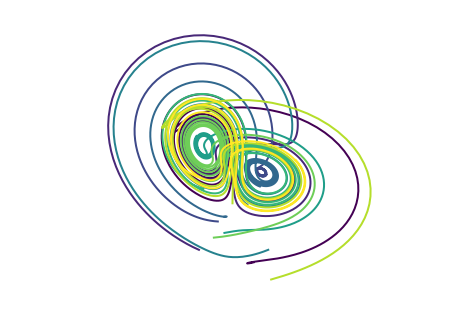

In [5]:
t, x_t = solve_lorenz(angle=0, N=10) #angle initially at 0, butterfly at 134

In [6]:

widget = interactive(solve_lorenz, angle=(0.,360.), max_time=(0.1, 4.0),
                N=(0,50), sigma=(0.0,50.0), rho=(0.0,50.0))
display(widget)

A Jupyter Widget

In [7]:
t, x_t = widget.result

In [8]:
#print(x_t)

In [9]:
widget.kwargs

{'N': 10,
 'angle': 0.0,
 'beta': 2.6666666666666665,
 'max_time': 4.0,
 'rho': 28.0,
 'sigma': 10.0}

In [10]:
xyz_avg = x_t.mean(axis=1)

In [11]:
xyz_avg.shape

(10, 3)

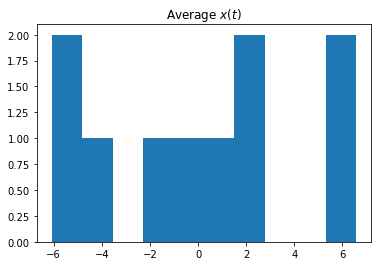

In [12]:
plt.hist(xyz_avg[:,0])
plt.title('Average $x(t)$');

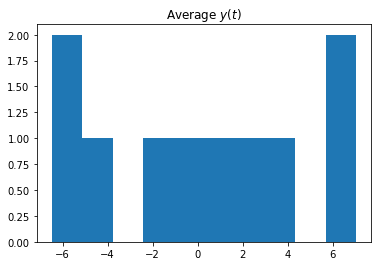

In [13]:
plt.hist(xyz_avg[:,1])
plt.title('Average $y(t)$');

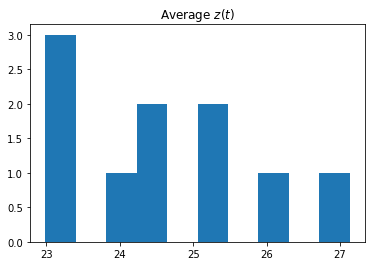

In [14]:
plt.hist(xyz_avg[:,2])
plt.title('Average $z(t)$');

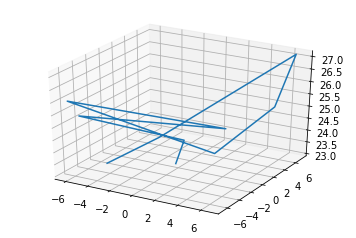

In [15]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(xyz_avg[:,0], xyz_avg[:,1], xyz_avg[:,2])
plt.show()

## Convert data into format for Keras

In [16]:
# split into train and test sets
train_size = int(len(x_t)* 0.70)
print(train_size)
test_size = len(x_t) - train_size
lorenz_train = x_t[0:train_size]
lorenz_test  = x_t[train_size:len(x_t)]
print ("train shape : " , lorenz_train.shape)
print ("test shape : " , lorenz_test.shape)

7
train shape :  (7, 1000, 3)
test shape :  (3, 1000, 3)


In [17]:

def to_sequences(seq_size, obs): 
    x = []
    y = []
    for i in range(len(obs)-SEQUENCE_SIZE-1):
        #print(i)
        window = obs[i:(i+SEQUENCE_SIZE)]
        after_window = obs[i+SEQUENCE_SIZE]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
    return np.array(x),np.array(y)

In [18]:
SEQUENCE_SIZE = 10
x_train, y_train = to_sequences(SEQUENCE_SIZE,lorenz_train)
x_test,y_test = to_sequences(SEQUENCE_SIZE,lorenz_test)
print("Shape of training set: {}".format(lorenz_train.shape))
print("Shape of test set: {}".format(lorenz_test.shape))
print("Shape of training set: {}".format(x_train.shape))

Shape of training set: (7, 1000, 3)
Shape of test set: (3, 1000, 3)
Shape of training set: (0,)


## Build Neural Network model in Keras

In [19]:
print('Build model...')
model = Sequential()
model.add(LSTM(64, batch_input_shape=(None, 3))) #https://faroit.github.io/keras-docs/1.0.1/getting-started/sequential-model-guide/
#model.add(Flatten())
model.add(Dense(32))
model.add(Dense(3))
model.compile(loss='mean_squared_error', optimizer='adam')

#monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
print('Train...')

Build model...


ValueError: Input 0 is incompatible with layer lstm_1: expected ndim=3, found ndim=2

## Plot original values and predictions

   '''
    plt.plot(x, y, z, '-')
    #plt.ylabel('some numbers')
    plt.xlabel('Logistics')
    plt.show()
   ''' 

## Calculate difference between prediction and actual